In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
gtzan = '/content/drive/MyDrive/MiniProject/GTZANUpdated'
genre_folders=os.listdir(gtzan)
print(genre_folders)
genre_files={}
for genre in genre_folders:
  genre_files[genre]=os.listdir(os.path.join(gtzan,genre))
print(genre_files)

['blues', 'classical', 'pop', 'disco', 'metal', 'hiphop', 'reggae', 'jazz', 'rock', 'country']
{'blues': ['blues.00000.wav', 'blues.00011.wav', 'blues.00007.wav', 'blues.00003.wav', 'blues.00010.wav', 'blues.00005.wav', 'blues.00002.wav', 'blues.00004.wav', 'blues.00006.wav', 'blues.00012.wav', 'blues.00008.wav', 'blues.00009.wav', 'blues.00013.wav', 'blues.00001.wav', 'blues.00021.wav', 'blues.00023.wav', 'blues.00016.wav', 'blues.00024.wav', 'blues.00025.wav', 'blues.00015.wav', 'blues.00018.wav', 'blues.00022.wav', 'blues.00019.wav', 'blues.00020.wav', 'blues.00017.wav', 'blues.00014.wav', 'blues.00029.wav', 'blues.00038.wav', 'blues.00028.wav', 'blues.00037.wav', 'blues.00031.wav', 'blues.00032.wav', 'blues.00034.wav', 'blues.00030.wav', 'blues.00036.wav', 'blues.00035.wav', 'blues.00027.wav', 'blues.00039.wav', 'blues.00033.wav', 'blues.00026.wav', 'blues.00051.wav', 'blues.00046.wav', 'blues.00052.wav', 'blues.00044.wav', 'blues.00050.wav', 'blues.00047.wav', 'blues.00053.wav', '

In [3]:
import librosa
import numpy as np
# def extract mfcc features given a file path
def extract_and_pad_stft_features(file_path, max_len=200):
    # Load audio file using librosa
    y, sr = librosa.load(file_path, sr=None)
    # Compute STFT
    stft = np.abs(librosa.stft(y))
    # Pad or trim STFT to max_len
    if stft.shape[1] < max_len:
        stft = np.pad(stft, ((0, 0), (0, max_len - stft.shape[1])), mode='constant')
    else:
        stft = stft[:, :max_len]
    return stft

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
stft_x = []
stft_y = []

for genre, files in genre_files.items():
    for file in tqdm(files, desc=f"Processing {genre}"):
        mfcc = extract_and_pad_stft_features(os.path.join(gtzan, genre, file))
        if mfcc is not None:
          stft_x.append(mfcc)
          stft_y.append(genre_folders.index(genre))


Processing country: 100%|██████████| 120/120 [00:57<00:00,  2.07it/s]


In [5]:
max_length = max([stft.shape[1] for stft in stft_x])

# Pad the sequences to have the same length
stft_X = np.array([np.pad(stft, ((0, 0), (0, max_length - stft.shape[1])), mode='constant') for stft in stft_x])

# Convert y to a NumPy array
stft_y = np.array(stft_y)

# Add a channel dimension to X
stft_X = stft_X[..., np.newaxis]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(stft_X, stft_y, test_size=0.01, random_state=42)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(genre_folders), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
35/35 [==============================] - 62s 2s/step - loss: 9.9963 - accuracy: 0.1977 - val_loss: 1.2958 - val_accuracy: 0.6667
Epoch 2/15
35/35 [==============================] - 60s 2s/step - loss: 1.4358 - accuracy: 0.5152 - val_loss: 1.1375 - val_accuracy: 0.5000
Epoch 3/15
35/35 [==============================] - 61s 2s/step - loss: 0.7314 - accuracy: 0.7683 - val_loss: 0.6247 - val_accuracy: 0.8333
Epoch 4/15
35/35 [==============================] - 60s 2s/step - loss: 0.3184 - accuracy: 0.9079 - val_loss: 0.9493 - val_accuracy: 0.7500
Epoch 5/15
35/35 [==============================] - 60s 2s/step - loss: 0.2002 - accuracy: 0.9428 - val_loss: 1.5825 - val_accuracy: 0.5833
Epoch 6/15
35/35 [==============================] - 60s 2s/step - loss: 0.1435 - accuracy: 0.9606 - val_loss: 1.3801 - val_accuracy: 0.6667
Epoch 7/15
35/35 [==============================] - 60s 2s/step - loss: 0.1206 - accuracy: 0.9651 - val_loss: 0.7240 - val_accuracy: 0.7500
Epoch 8/15
35/35 [==

In [7]:
model.save('/content/drive/MyDrive/MiniProject/Models/cnn-stft-100-15-old.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
loss, overall_accuracy = model.evaluate(X_test, y_test)
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")

genre_accuracies = []
genre_names = []
genre_to_label = {genre: i for i, genre in enumerate(genre_folders)}
# X_train, X_test, y_train, y_test = train_test_split(mfcc_X, mfcc_y, test_size=0.3, random_state=50)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

for genre in genre_folders:
    genre_index = genre_to_label[genre]
    genre_indices = np.where(y_true == genre_index)[0]
    if len(genre_indices) > 0:
        genre_accuracy = np.mean(y_pred_classes[genre_indices] == y_true[genre_indices])
        genre_accuracies.append(genre_accuracy)
        genre_names.append(genre.capitalize())
        print(f"Accuracy for {genre.capitalize()}: {genre_accuracy * 100:.2f}%")



1/1 [==============================] - 0s 167ms/step - loss: 1.4365 - accuracy: 0.5833
Overall Test Accuracy: 58.33%
1/1 [==============================] - 0s 234ms/step
Accuracy for Classical: 100.00%
Accuracy for Pop: 100.00%
Accuracy for Metal: 50.00%
Accuracy for Reggae: 0.00%
Accuracy for Jazz: 100.00%
Accuracy for Rock: 100.00%
Accuracy for Country: 0.00%


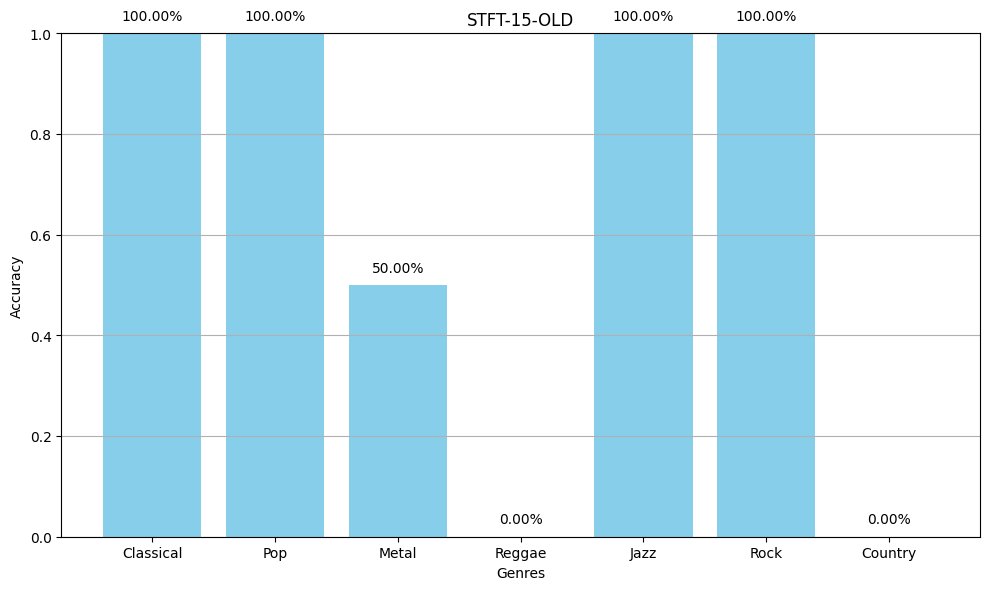

In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(genre_names, genre_accuracies, color='skyblue')
plt.title('STFT-15-OLD')
plt.xlabel('Genres')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set ylim to 0-100%
plt.grid(axis='y')
for i, v in enumerate(genre_accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

20 Epoch

In [10]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(genre_folders), activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model2.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
35/35 [==============================] - 62s 2s/step - loss: 5.2545 - accuracy: 0.1172 - val_loss: 2.2806 - val_accuracy: 0.0833
Epoch 2/20
35/35 [==============================] - 60s 2s/step - loss: 1.9452 - accuracy: 0.3274 - val_loss: 1.6077 - val_accuracy: 0.5000
Epoch 3/20
35/35 [==============================] - 60s 2s/step - loss: 0.9071 - accuracy: 0.7236 - val_loss: 1.0406 - val_accuracy: 0.6667
Epoch 4/20
35/35 [==============================] - 60s 2s/step - loss: 0.2909 - accuracy: 0.9159 - val_loss: 1.4393 - val_accuracy: 0.5833
Epoch 5/20
35/35 [==============================] - 60s 2s/step - loss: 0.1593 - accuracy: 0.9544 - val_loss: 2.1577 - val_accuracy: 0.4167
Epoch 6/20
35/35 [==============================] - 60s 2s/step - loss: 0.1303 - accuracy: 0.9624 - val_loss: 1.8113 - val_accuracy: 0.5833
Epoch 7/20
35/35 [==============================] - 60s 2s/step - loss: 0.1094 - accuracy: 0.9732 - val_loss: 1.9688 - val_accuracy: 0.5833
Epoch 8/20
35/35 [==

In [11]:
model2.save('/content/drive/MyDrive/MiniProject/Models/cnn-stft-100-20-old.h5')
loss, overall_accuracy = model2.evaluate(X_test, y_test)
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")

genre_accuracies = []
genre_names = []
genre_to_label = {genre: i for i, genre in enumerate(genre_folders)}
# X_train, X_test, y_train, y_test = train_test_split(mfcc_X, mfcc_y, test_size=0.3, random_state=50)
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

for genre in genre_folders:
    genre_index = genre_to_label[genre]
    genre_indices = np.where(y_true == genre_index)[0]
    if len(genre_indices) > 0:
        genre_accuracy = np.mean(y_pred_classes[genre_indices] == y_true[genre_indices])
        genre_accuracies.append(genre_accuracy)
        genre_names.append(genre.capitalize())
        print(f"Accuracy for {genre.capitalize()}: {genre_accuracy * 100:.2f}%")



1/1 [==============================] - 0s 166ms/step - loss: 3.3008 - accuracy: 0.5000
Overall Test Accuracy: 50.00%
1/1 [==============================] - 0s 219ms/step
Accuracy for Classical: 100.00%
Accuracy for Pop: 100.00%
Accuracy for Metal: 50.00%
Accuracy for Reggae: 0.00%
Accuracy for Jazz: 100.00%
Accuracy for Rock: 50.00%
Accuracy for Country: 0.00%


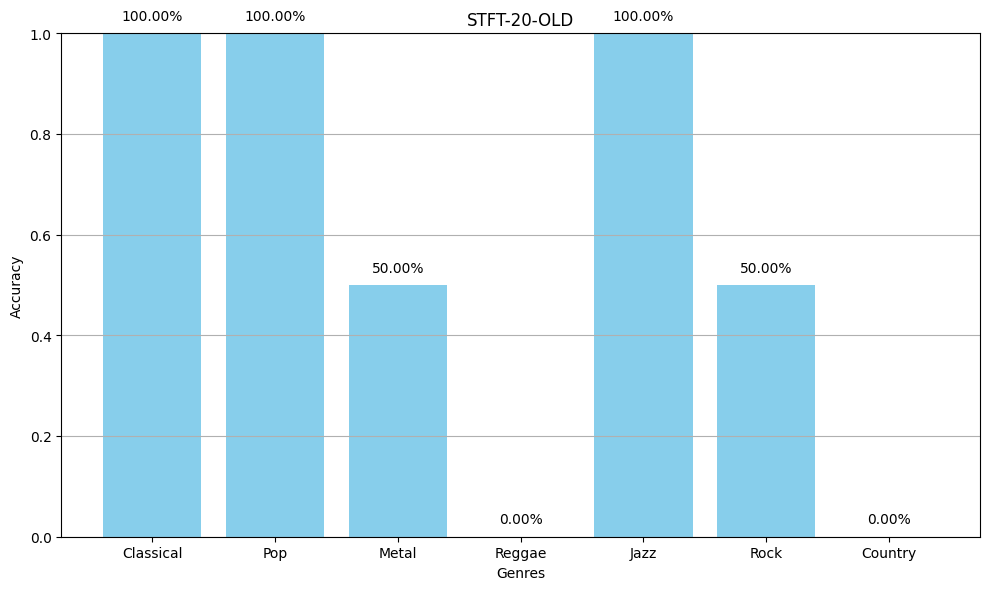

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(genre_names, genre_accuracies, color='skyblue')
plt.title('STFT-20-OLD')
plt.xlabel('Genres')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set ylim to 0-100%
plt.grid(axis='y')
for i, v in enumerate(genre_accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()